# LIME Explanations with Keras-Image-Recognition
This Notebook covers some basics how to use the LIME-Explainer for Image-Recognition. 

Therefore we will look at an AI trained to detect german traffic signs. Everything you need should be around. 

While the very basics are very fast shown, i will also try to show you some problems I found in my AI using LIME. 

In [71]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# IMG MANIPULATION
from scipy import ndimage
from scipy import misc as scipyMisc

#This import contains our labels and strings.
import LabelDictionary as LDic

# Additional:
# LIME needs to be installed via pip

Define required Methods to: 
* show us a single image
* load our model
* predict an image

*Note*: The Load-Model is a little more complex. 
This originates from Keras, which sometimes tries to play a trick on you. Not with me, darling.

In [74]:
def load_model(path):
    loaded = tf.keras.models.load_model(
        path,
        custom_objects=None,
        compile=False
    )
    # The Compile-Parameters are a secret only known to me  
    loaded.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return loaded

def load_ppm_image(path):
    raw = mpimg.imread(path)
    # Not every Image has the same size. Our Model can just handle 64x64 RGB Images, therefore we need to resize the image.
    # Bicubic interpolation looks very good, bilinear is also good, nearest looks like Würfelhusten
    resized = scipyMisc.imresize(raw, (64,64,3), interp='bicubic', mode=None)
    return resized

def predict_single_image(model,img):
    imgArr = (np.expand_dims(img,0)) # Keras Models want to batch-predict images. Therefore we create a single element array
    imgArr = imgArr/255 # Aphrodite was trained with Values normed [0,1]
    return model.predict(imgArr)[0],img

Ok, now lets load our Model and have a look at it, if everything is in Order. 

In [68]:
aphrodite = load_model("Aphrodite.h5")
aphrodite.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 128)       0         
__________

**Great!** 

Lets inspect an Image. 

The following image shows "Überhohlverbot for LKWs over 3.5t", and is a little blurry. The original image was only 34x34 and got quite a stretch. 

C:\Users\lguts\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


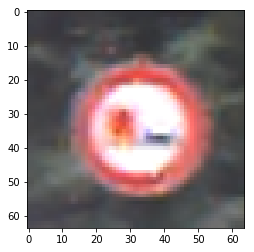

In [75]:
lkwÜVerbot = load_ppm_image("lkwUEVerbot.ppm")
plt.imshow(lkwÜVerbot)
plt.show()

Lets see what our model thinks about it: 


We let our model predict the image, and look at the array of scores. the argmax() gives us the index of the element with the highest value. This equals our label. 

In [76]:
scores,_=predict_single_image(aphrodite,lkwÜVerbot)
print(scores.argmax(),scores[scores.argmax()])
LDic.INT_TO_LABEL[scores.argmax()]

10 1.0


'no_overtaking_trucks'

Nice, we've even got ourselves some new Vocabulary. So the Prediction clearly shows the same what we expected: The correct sign. 

Now let's dive into the LIME prediction and inspect why we got these results. 

First we need to import the LIME packages.

In [7]:
from lime import lime_image
import time
# To show the image with a mask
from skimage.segmentation import mark_boundaries

Next we need to initialise our explainer. 

In [8]:
explainer = lime_image.LimeImageExplainer()

Now we can start explaining our model. 

The explainer requires:
* an image (our LKW Picture above, but we need to scale it for aphrodite) 
* an prediction method as function
* a number of labels (we take all here) 
* a number of samples

We also stop the time the explainer needs. You can vary the num_samples and the top_labels to check how the time differs.

In [12]:
%%time
explanation = explainer.explain_instance(lkwÜVerbot/255, aphrodite.predict, top_labels=43, hide_color=0, num_samples=1000)

Wall time: 4.19 s


The *explanation*-object has quite a lot of interesting attributes, which you can lookup [here](https://github.com/marcotcr/lime/blob/master/lime/explanation.py) (line 94ff). 

I've implemented the most interesting feature: 

Highlighting what parts of the image where important for our prediction! 

Therefore we have a fitting method in the explanation, which requires the label we want to know and a number of features.

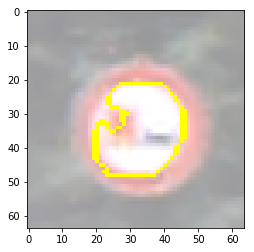

In [15]:
temp, mask = explanation.get_image_and_mask(10, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

**Wow!** 

We can see, that only the interior of the sign was important for the model, the trees are fully ignored and most of the sign-edge too. 

This is somewhat reasonable, as there are a lot of signs which are round, therefore the shape is not that important. 

Let's take a look at a different label for the same image. We've earlier seen that we had 100% accuracy for Label 10, so every other label has an accuracy of 0. 

This time we alter our display: 

We not only take parts which affected the prediction positive, but also which ones *didn't*. The red parts show us which affected the prediction negative.

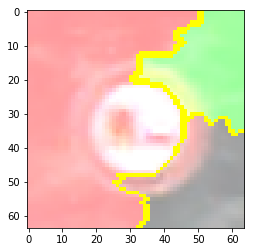

In [26]:
temp, mask = explanation.get_image_and_mask(11, positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

What a mess! 

Atleast we can see, that the sign itself is red. Some of the bushes are somewhat green, but this explanation is not very helpfull. 

If you increase the number of features, there will be a lot more bushes marked as "positive". 

If you decrease the number of features (try **1**) you will get the traffic sign itself marked as red. This is not that very helpfull, but atleast a very good explanation whats going on: The model saw the traffic sign, and this affected the prediction for Label 11 in a very negative way. 

The Features are ordered by their weight. Everything after the first one (the sign itself) is just peanuts. 

### Overfitting
After these basics, I've found a little problem in my very own data. 

Let's take a look at another picture I've taken from my **training set** and explain it the very same way above.



C:\Users\lguts\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


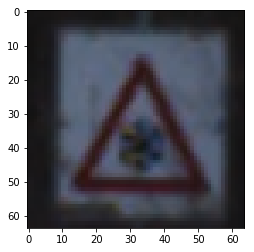

In [27]:
frostImg = load_ppm_image("frost.ppm")
plt.imshow(frostImg)
plt.show()

Interpolation also takes it's toll on the poor Snowflake. 

But the Trainingdata didn't have that many of these shields, so I wanted to get every sign of the data. 

Let's see how our Model performs:

In [29]:
s2,_=predict_single_image(aphrodite,frostImg)
print(s2.argmax(),s2[s2.argmax()])
LDic.INT_TO_LABEL[s2.argmax()]

30 1.0


'attention_snowflake'

With 100% accuracy our model performs an correct prediction with inhuman quality. 

As we also want these kind of magic tricks, we ask our explainer how this worked:

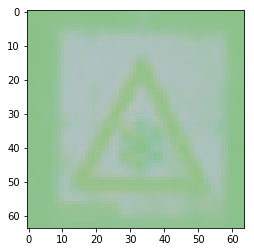

In [33]:
explanation2 = explainer.explain_instance(frostImg/255, aphrodite.predict, top_labels=43, hide_color=0, num_samples=1000)
temp, mask = explanation2.get_image_and_mask(30, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

It just remembers the image. Poor Aphrodite didn't learn really features. 

As mentioned earlier, this image was taken from the training set and snow-warning images are quite rare.
The Model was able to learn this image. 

This is one point where we can improve our model: We need to generalize snowflakes a little better. This only applies to AI's not to our society

### Similiar Items
Ok, now we get to a sticky part: we take two similiar images. For this example we take a picture of a "70"-Zone and a "60"-Zone. 
    
These are quite similiar and only differ in a single number on the sign. 

The next command took me roughly a minute, if you take longer think about upgrading your hardware. 

In [42]:
%%time
sechzigImg = load_ppm_image("60.ppm")
explanation4 = explainer.explain_instance(sechzigImg/255, aphrodite.predict, top_labels=10, hide_color=0, num_samples=10000)
siebzigImg = load_ppm_image("70.ppm")
explanation5 = explainer.explain_instance(siebzigImg/255, aphrodite.predict, top_labels=10, hide_color=0, num_samples=10000)

C:\Users\lguts\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\lguts\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Wall time: 1min 20s


Now we can inspect these predictions. 

Note that I've reduced the number of features to **1** each, you can increase this number for your own visualisation, but the best effects are seen this way

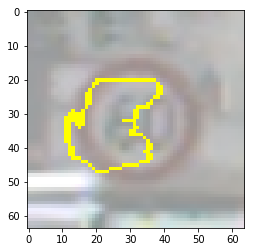

In [44]:
#Label for "60" is 3
temp, mask = explanation4.get_image_and_mask(3, positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

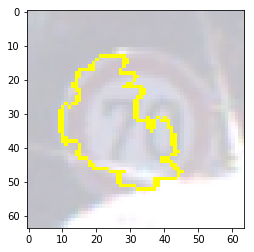

In [46]:
#Label for "70" is 4
temp, mask = explanation5.get_image_and_mask(4, positive_only=True, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

**NICE!**

Aphrodite is quite a smart beauty, she's not only studying the images - she knows whats going on.
We can clearly see that our Model is able to find a single literal in a very blurry image and predict accordingly. 

This is clearly expected behaviour and very nice to see. We can trust our model in terms of speed limits. 

## Big Aphrodite
Sanitycheck with my much better Model!

Not in the Repo, sorry, its 50mb

In [121]:
bigAphrodite = load_model("BigAphrodite.h5")
bigAphrodite.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
__________

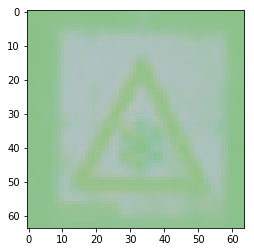

Wall time: 1min 38s


In [127]:
%%time
explanation3 = explainer.explain_instance(frostImg/255, bigAphrodite.predict, top_labels=43, hide_color=0, num_samples=10000)
temp, mask = explanation3.get_image_and_mask(30, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

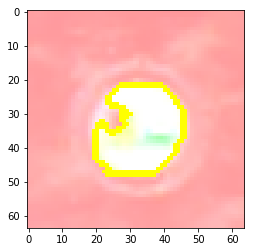

Wall time: 8.63 s


In [126]:
%%time
explanation4 = explainer.explain_instance(lkwÜVerbot/255, bigAphrodite.predict, top_labels=43, hide_color=0, num_samples=1000)
temp, mask = explanation4.get_image_and_mask(10, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()